# Pairs Trading Strategy (Statistical Arbitrage)
Goal: Identify cointegrated pairs, construct spread, generate z-score signals and backtest simple long-short strategy.


In [8]:
!pip install yfinance statsmodels --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import yfinance as yf

plt.style.use('default')


In [9]:
# Real data example (uncomment to use):
# tickers = ['KO','PEP']
# data = yf.download(tickers, start='2018-01-01', end='2024-01-01')['Adj Close'].dropna()
# prices = data

# Synthetic fallback:
np.random.seed(0)
n = 500
s1 = np.cumsum(np.random.normal(0,1,n)) + 50
s2 = s1 * 0.8 + np.random.normal(0,1,n) + 10
dates = pd.date_range('2020-01-01', periods=n)
prices = pd.DataFrame({'S1': s1, 'S2': s2}, index=dates)

prices.tail()


,S1,S2
2021-05-10,39.591464,42.086042
2021-05-11,38.932911,40.947930
2021-05-12,38.418677,40.829134
2021-05-13,37.400635,38.772897
2021-05-14,37.322780,39.500110


In [10]:
score, pvalue, _ = coint(prices['S1'], prices['S2'])
print("Cointegration p-value:", pvalue)

# OLS hedge ratio S1 ~ beta * S2
y = prices['S1']
X = sm.add_constant(prices['S2'])
res = sm.OLS(y, X).fit()
beta = res.params['S2']
print("Hedge ratio (beta):", beta)


Cointegration p-value: 0.0
Hedge ratio (beta): 1.2442600048074677


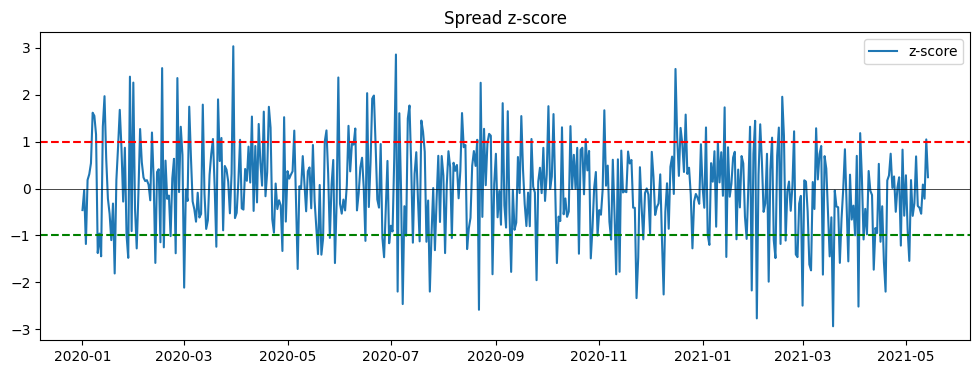

In [11]:
spread = prices['S1'] - beta * prices['S2']
zscore = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(12,4))
plt.plot(zscore, label='z-score')
plt.axhline(1.0, color='r', linestyle='--')
plt.axhline(-1.0, color='g', linestyle='--')
plt.axhline(0, color='k', linewidth=0.5)
plt.legend()
plt.title('Spread z-score')
plt.show()


In [12]:
entry_z = 1.0
exit_z = 0.0

positions = pd.DataFrame(0, index=prices.index, columns=['S1','S2'])
current_pos = 0  # 1 = long spread (long S1 short S2), -1 = short spread

for i in range(1, len(zscore)):
    if current_pos == 0:
        if zscore.iloc[i] > entry_z:
            current_pos = -1   # short spread
        elif zscore.iloc[i] < -entry_z:
            current_pos = 1    # long spread
    elif current_pos == 1 and zscore.iloc[i] >= exit_z:
        current_pos = 0
    elif current_pos == -1 and zscore.iloc[i] <= exit_z:
        current_pos = 0

    if current_pos == 1:
        positions.iloc[i] = [1, -beta]
    elif current_pos == -1:
        positions.iloc[i] = [-1, beta]
    else:
        positions.iloc[i] = [0,0]

positions.head()


/tmp/ipython-input-2675135018.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.2442600048074677' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions.iloc[i] = [1, -beta]


,S1,S2
2020-01-01,0,0.00000
2020-01-02,0,0.00000
2020-01-03,1,-1.24426
2020-01-04,0,0.00000
2020-01-05,0,0.00000


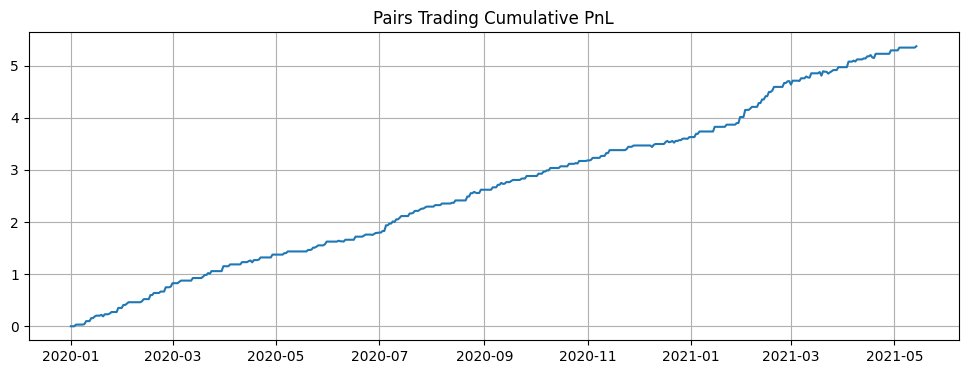

Total PnL: 5.372680383117458


In [13]:
returns = prices.pct_change().fillna(0)
pnl = (positions.shift(1) * returns).sum(axis=1)
cum_pnl = pnl.cumsum()

plt.figure(figsize=(12,4))
plt.plot(cum_pnl)
plt.title('Pairs Trading Cumulative PnL')
plt.grid(True)
plt.show()

print("Total PnL:", cum_pnl.iloc[-1])


### Extensions
- Add transaction costs and slippage.
- Use rolling-window cointegration & dynamic hedge ratios.
- Scale positions by volatility or dollar-neutral sizing.
